In [1]:
class MyRegressor:
    def __init__(self) -> None:
        self.W = []
        self.X = []

    def get_parameters(self):
        return self.W
    
    def predict(self,x):
        l = []
        for i in range(len(x)):
            c = self.W[0][-1]
            for j in range(len(x[i])):
                c += float(self.W[j+1][-1]) * x[i][j]
            l.append(c)
        return l

    def train(self, training_input_set, training_output_set):
        self.X = [[1] + x.copy() for x in training_input_set]
        XT = self.__transpose_matrix(self.X)
        P = self.__product(XT,self.X)
        P_Invers = self.__inversa(P)
        A = self.__product(P_Invers,XT)
        Y = [[el] for el in training_output_set.copy()]
        self.W = self.__product(A,Y)
        
        
    def __transpose_matrix(self, A):
        n, m = len(A), len(A[-1])
        XT = [[] for _ in range(m)]
        for i in range(n):
            for j in range(m):
                XT[j].append(A[i][j])
        return XT

    def __product(self,A,B):
        nr_lines = len(A)
        nr_cols = len(B[-1])
        prod = []
        for i in range(nr_lines):
            prod.append([])
            for j in range(nr_cols):
                prod[i].append(sum([A[i][k] * B[k][j] for k in range(len(A[i]))]))
        return prod          

    def __elimLinCol(self, A, i:int, j:int):
        B  = [ A[k].copy() for k in range(len(A)) if k != i ]
        for line in B:
            line.pop(j)
        return B

    def __determinant(self, A):
        if len(A) == 1:
            return A[-1][-1]
        return sum(((-1) ** j) * A[0][j] * self.__determinant(self.__elimLinCol(A,0,j)) for j in range(len(A[0])))

    def __inversa(self, A):
        dA = self.__determinant(A)
        B = []
        nr_lines = len(A)
        nr_cols = len(A[-1])
        for i in range(nr_lines):
            B.append([])
            for j in range(nr_cols):
                B[i].append(((-1) ** (i+j)) * self.__determinant(self.__elimLinCol(A,i,j))/dA)
        return B



In [2]:
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_6742/1505719282.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Happiness by GDP and Freedom

In [3]:
def readDatas(dataPath: str):
    df = pd.read_csv(dataPath,delimiter=',', header='infer')
    return df.dropna()

In [8]:
import numpy as np
def getTrainingAndValidationSets2(df_world_happiness):
    dataSize = df_world_happiness.shape[0]
    trainingIndexSet = np.random.choice(range(dataSize),size=int(0.8 * dataSize),replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet] 

    trainingInputSet = [[df_world_happiness["Economy..GDP.per.Capita."].iloc[index], df_world_happiness["Freedom"].iloc[index]] for index in trainingIndexSet ]
    trainingOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in trainingIndexSet ]

    validationInputSet = [[df_world_happiness["Economy..GDP.per.Capita."].iloc[index],df_world_happiness["Freedom"].iloc[index]] for index in validationIndexSet ]
    validationOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in validationIndexSet ]
    
    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet

In [9]:
def happinessByGDPAndFreedom(world_happiness):
    
    training_input_set, training_output_set, validation_input_set, validation_output_set = getTrainingAndValidationSets2(world_happiness)
    regressor = MyRegressor()
    regressor.train(training_input_set, training_output_set)
    
    W = regressor.get_parameters()
    w0, w1, w2 = W[0][-1], W[1][-1], W[2][-1]

    # Generate data for plotting the plane
    x_min, x_max = np.min(training_input_set, axis=0)[0], np.max(training_input_set, axis=0)[0]
    y_min, y_max = np.min(training_input_set, axis=0)[1], np.max(training_input_set, axis=0)[1]
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
    zz = w0 + w1 * xx + w2 * yy

    # Plot the data points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    training_input_set2 = np.array(training_input_set)
    training_output_set2 = np.array(training_output_set)
    ax.scatter(training_input_set2[:,0], training_input_set2[:,1], training_output_set, c='b', marker='o', label='Training Data')
    
    # Plot the plane representing the model
    ax.plot_surface(xx, yy, zz, alpha=0.5, cmap='viridis', label='Model Plane')
    
    ax.set_title('Training Data and Model Plane')
    ax.set_xlabel('GDP')
    ax.set_ylabel('Freedom')
    ax.set_zlabel('Happiness')
    
    plt.show()

    
    print("f(x) = {} + {}*x1+ {}*x2".format(w0,w1,w2))

    # Eroare
    computedValidationOutputs = regressor.predict([x for x in validation_input_set])
    manualError = 0.0
    for t1, t2 in zip(computedValidationOutputs, validation_output_set):
        manualError += (t1 - t2) ** 2
    manualError = manualError / len(validation_output_set)
    print("Eroare: {}".format(manualError))




In [10]:
world_happiness_v1 = readDatas("datas/v1_world-happiness-report-2017.csv")


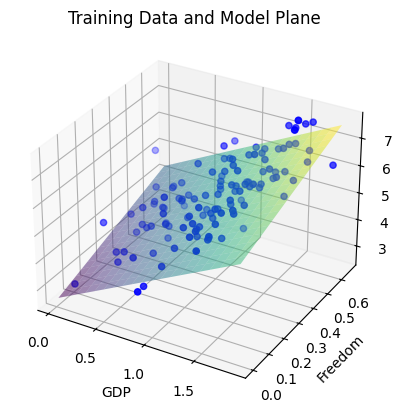

f(x) = 2.589387426621906 + 1.7716874566736416*x1+ 2.5228542157804474*x2
Eroare: 0.2940263482325188


In [11]:
happinessByGDPAndFreedom(world_happiness_v1)

In [12]:
def getTrainingAndValidationSets3(df_world_happiness):
    dataSize = df_world_happiness.shape[0]
    trainingIndexSet = np.random.choice(range(dataSize),size=int(0.8 * dataSize),replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet] 

    trainingInputSet = [df_world_happiness["Family"].iloc[index] for index in trainingIndexSet ]
    trainingOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in trainingIndexSet ]

    validationInputSet = [df_world_happiness["Family"].iloc[index] for index in validationIndexSet ]
    validationOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in validationIndexSet ]
    
    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet

def happinessByFamily(df_world_happiness):
    
    trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet = getTrainingAndValidationSets3(df_world_happiness)
    newTrainingInputSet = [[el] for el in trainingInputSet]
    regressor = MyRegressor()
    regressor.train(newTrainingInputSet,trainingOutputSet)
    w0, w1 = regressor.get_parameters()[0][-1], regressor.get_parameters()[1][-1]
    noOfPoints = 1000
    xref = []
    val = min(trainingInputSet)
    step = (max(trainingInputSet) - min(trainingInputSet)) / noOfPoints
    for i in range(1, noOfPoints):
        xref.append(val)
        val += step
    yref = [w0 + w1 * el for el in xref] 

    fix,axes = plt.subplots()

    axes.plot(trainingInputSet, trainingOutputSet, 'ro', label = 'training data')  #train data are plotted by red and circle sign
    axes.plot(xref, yref, 'b-', label = 'learnt model')                  #model is plotted by a blue line
    axes.set_title('train data and the learnt model')
    axes.set_xlabel('Family')
    axes.set_ylabel('happiness')
    axes.legend()
    plt.show()

    print("f(x) = {} + {}*x".format(w0,w1))

    computedValidationOutputs = regressor.predict([[x] for x in validationInputSet])
    manualError = 0.0
    for t1, t2 in zip(computedValidationOutputs, validationOutputSet):
        manualError += (t1 - t2) ** 2
    manualError = manualError / len(validationOutputSet)
    print("Eroarea: ",manualError)

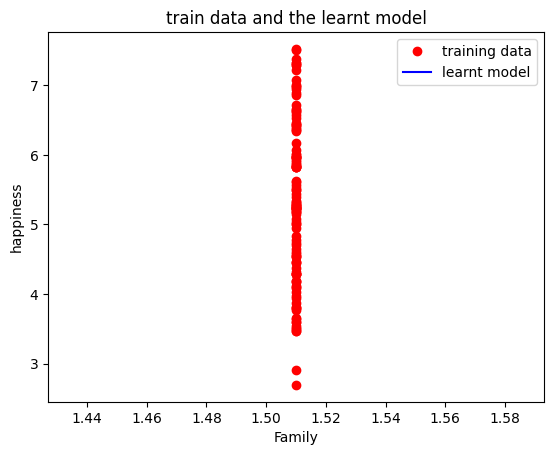

f(x) = -3.8665839820078105 + 5.799875973011717*x
Eroarea:  1.5123779329690523


In [13]:
happinessByFamily(world_happiness_v1)